# Feature Visualization – A Media-archaeological Exploration of Explainable Machine Learning

(c) 2021-25 Fabian Offert

## Colab Setup

**Before anything else, change the runtime type to "GPU"**

In [1]:
# @title Click to expand
# Set up to run on Colab
!rm -rf minimal # In case this is re-run
!git clone https://github.com/zentralwerkstatt/minimal
!cp ./minimal/synset_words.txt ./

Cloning into 'minimal'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 23 (delta 6), reused 8 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (23/23), 822.98 KiB | 2.72 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [2]:
!nvidia-smi # Check what kind of GPU we got

Mon Jul  7 22:08:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Imports

We are using PyTorch, the de-facto standard for high-level prototyping for machine learning. Because we are operating in high-dimensional vector space, we are also using Numpy, the Python library for scientific computing. Finally, we are importing several ready-to-use image filters, and some helper libraries.

In [ ]:
# @title Click to expand
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv

import numpy as np

from scipy.ndimage import gaussian_filter, median_filter
from skimage.restoration import denoise_bilateral, denoise_tv_chambolle
import PIL.Image, PIL.ImageChops

import os
import random
from io import BytesIO
from IPython import display

## Model to investigate

This may take a while, as the pre-trained weights have to be loaded on first run.

In [ ]:
device = t.device("cuda:0" if t.cuda.is_available() else "cpu") # Use GPU if available
f1 = tv.models.inception_v3(weights=True).to(device)
f2 = tv.models.vgg16(weights=True).to(device)
f3 = tv.models.vgg19(weights=True).to(device)
# Test mode: we do not want to train the model (i.e. change its weights) at any point
f1.eval()
f2.eval()
f3.eval()
model_names = {'f1':'Inception V3', 'f2':'VGG16', 'f3': 'VGG19'}

## Helper functions

Among other things, these helper functions allow us to convert between PyTorch tensors, NumPy arrays, and PIL images.

In [5]:
# @title Click to expand
# Show an image within a Jupyter environment
# Can do PyTorch tensors, NumPy arrays, and PIL images
def show_img(img, title='', fmt='jpeg'):
    if type(img) is np.ndarray:
        img = PIL.Image.fromarray(img)
    elif type(img) is t.Tensor:
        img = deprocess(img)
    out = BytesIO()
    if title: print(title)
    img.save(out, fmt)
    display.display(display.Image(data=out.getvalue()))

# PyTorch is channels first, this happens here!
preprocess = tv.transforms.Compose([tv.transforms.ToTensor()])

# Reverse of preprocess, PyTorch tensor to PIL image
def deprocess(tensor):
    # Clone tensor first, otherwise we are NOT making a copy by using .cpu()!
    img = t.clone(tensor)
    img = img.cpu().data.numpy().squeeze() # Get rid of batch dimension
    img = img.transpose((1, 2, 0)) # Channels first to channels last

    # We are not using ImageNet images as input
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # img = std * img + mean

    # No clipping, adversarial regulation should take care of this
    # img = np.clip(img, 0, 1)

    # 0./1. range to 0./255. range
    img *= 255

    img = img.astype(np.uint8)
    img = PIL.Image.fromarray(img)
    return img

# Return a gray square PIL image
def gray_square(size):
    # Gray square, -1./1. range
    img = np.random.normal(0, 0.01, (size, size, 3))

    # -1./1. range to 0./255. range
    img /= 2.
    img += 0.5
    img *= 255.

    img = img.astype(np.uint8)
    img = PIL.Image.fromarray(img)
    return img

# Load ImageNet classes
with open('synset_words.txt') as synset_words_file:
    synset_words = synset_words_file.readlines()
for i, line in enumerate(synset_words):
    synset_words[i] = line.replace(' ', '_').replace(',', '_').lower().strip()

# Classify an image with the target model
# Can do PyTorch tensors and PIL images
def predict(img, model):
    if type(img) is t.Tensor:
        preds = model(img.to(device))
    else:
        preds = model(preprocess(img).unsqueeze(0).to(device))
    preds_softmax_np = F.softmax(preds, dim=1).cpu().data.numpy()
    # Returns class no., class name, and prediction confidence
    return preds_softmax_np.argmax(), synset_words[preds_softmax_np.argmax()], preds_softmax_np.max()

# "Rolling" list: whenever an item is added, the first item is discarded
def destructive_append(l,i):
    l=l[1:]
    l.append(i)
    return l

# PyTorch and skimage use different channel ordering
def pytorch_to_skimage(img):
    # No batch dimension
    img = img[0]
    # Channels last
    img = np.swapaxes(img, 0, 2)
    return img

def skimage_to_pytorch(img):
    # Channels first
    img = np.swapaxes(img, 0, 2)
    # Skimage uses double
    img = img.astype(np.float32)
    # No Batch dimension
    img = np.expand_dims(img, 0)
    return img

# Filters for feature visualization
def filter_median(npimg, params):
    npimg = median_filter(npimg, size=(1, 1, params['fsize'], params['fsize']))
    return npimg

def filter_bilateral(npimg, params):
    npimg = pytorch_to_skimage(npimg)
    npimg = denoise_bilateral(npimg, sigma_color=0.05, sigma_spatial=15, multichannel=True)
    npimg = skimage_to_pytorch(npimg)
    return npimg

def filter_TV(npimg, params):
    npimg = pytorch_to_skimage(npimg)
    npimg = denoise_tv_chambolle(npimg, weight=0.1)
    npimg = skimage_to_pytorch(npimg)
    return npimg

## Gradient Ascent

This is the main visualization loop, where we slowly approximate an "optimal" image

In [6]:
# @title Click to expand
def gradient_ascent(img, neuron, model):

    ITERATIONS = 2000
    FILTERS = [{'function':filter_median, 'frequency':4, 'params':{'fsize':5}}] # Good parameters
    # FILTERS = [{'function':filter_TV, 'frequency':20, 'params':{}}] # Good parameters
    JITTER = 32
    LR = 0.4
    L2 = 1e-4 # Yosinski weight decay

    input = preprocess(img).unsqueeze(0).to(device).requires_grad_()
    optimizer = t.optim.SGD([input], lr=LR, weight_decay=L2)

    for i in range(ITERATIONS):

        optimizer.zero_grad()

        # Centers the object in the image
        if JITTER:
            npimg = input.data.cpu().numpy() # To CPU and numpy
            ox, oy = np.random.randint(-JITTER, JITTER+1, 2)
            npimg = np.roll(np.roll(npimg, ox, -1), oy, -2) # Jitter
            input.data = t.from_numpy(npimg).to(device)

        x = model(input)
        loss = -x[:,neuron]

        preds_softmax_np = F.softmax(x, dim=1).cpu().data.numpy()
        confidence = preds_softmax_np[:,neuron]

        if i%50 == 0:
            print(f'Iterations: {i}, loss: {loss.item()}, pred.: {synset_words[preds_softmax_np.argmax()]}, conf.: {confidence}')

        loss.backward()
        optimizer.step()

        # Centers the object in the image
        if JITTER:
            npimg = input.data.cpu().numpy() # To CPU and numpy
            npimg = np.roll(np.roll(npimg, -ox, -1), -oy, -2) # Jitter
            input.data = t.from_numpy(npimg).to(device)

        # Stochastic clipping
        input.data[input.data > 1] = np.random.uniform(0, 1)
        input.data[input.data < 0] = np.random.uniform(0, 1)

        # Filtering
        for filter_ in FILTERS:
            if i != ITERATIONS - 1: # No regularization on last iteration for good quality output
                if i % filter_['frequency'] == 0:
                    npimg = input.data.cpu().numpy() # To CPU and numpy
                    npimg = filter_['function'](npimg, filter_['params'])
                    input.data = t.from_numpy(npimg).to(device)
        # Verbose
        if i%50==0:
          show_img((input))

    return input

Iterations: 0, loss: 1.502989411354065, pred.: envelope, conf.: [0.00011941]


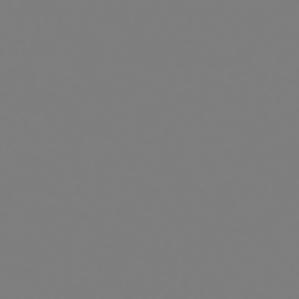

Iterations: 50, loss: -13.829930305480957, pred.: sea_lion, conf.: [0.99625176]


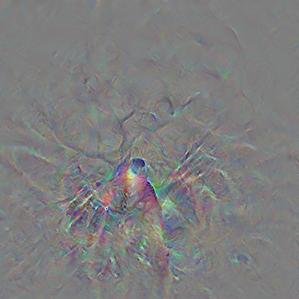

Iterations: 100, loss: -12.297682762145996, pred.: sea_lion, conf.: [0.988953]


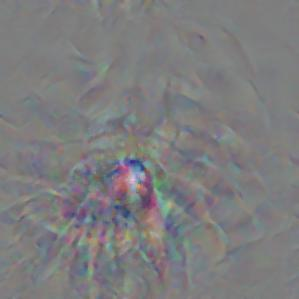

Iterations: 150, loss: -9.254155158996582, pred.: sea_lion, conf.: [0.7189236]


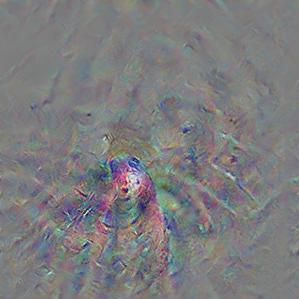

Iterations: 200, loss: -13.967933654785156, pred.: sea_lion, conf.: [0.98819435]


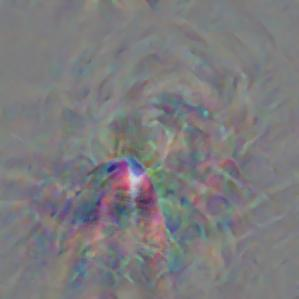

Iterations: 250, loss: -12.633478164672852, pred.: sea_lion, conf.: [0.9827983]


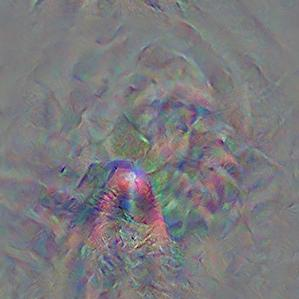

Iterations: 300, loss: -16.00313377380371, pred.: sea_lion, conf.: [0.9993048]


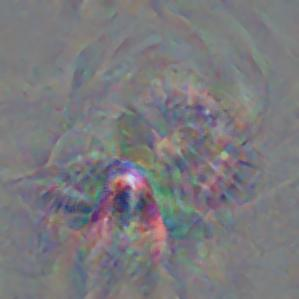

Iterations: 350, loss: -17.194725036621094, pred.: sea_lion, conf.: [0.99976605]


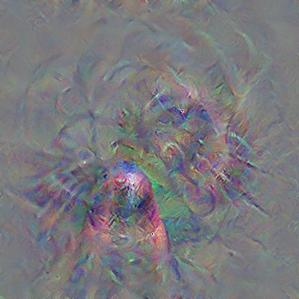

Iterations: 400, loss: -18.43502426147461, pred.: sea_lion, conf.: [0.99995685]


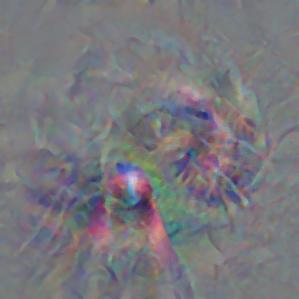

Iterations: 450, loss: -16.123186111450195, pred.: sea_lion, conf.: [0.9995303]


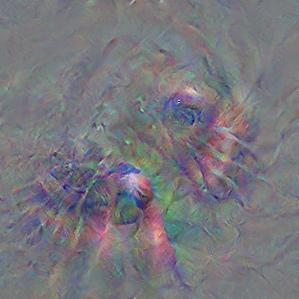

Iterations: 500, loss: -7.08340311050415, pred.: sea_lion, conf.: [0.34349358]


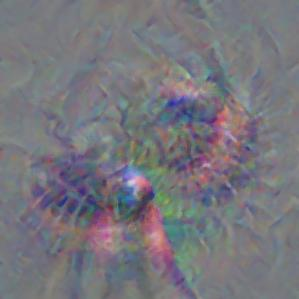

Iterations: 550, loss: -20.554250717163086, pred.: sea_lion, conf.: [0.9999049]


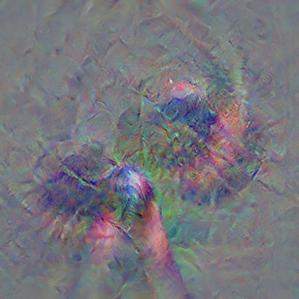

Iterations: 600, loss: -19.317195892333984, pred.: sea_lion, conf.: [0.99998164]


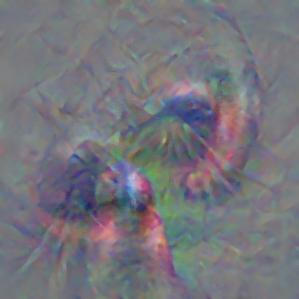

Iterations: 650, loss: -18.085712432861328, pred.: sea_lion, conf.: [0.9999553]


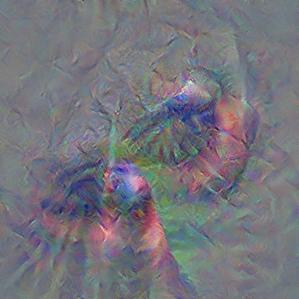

Iterations: 700, loss: -11.461546897888184, pred.: sea_lion, conf.: [0.97197706]


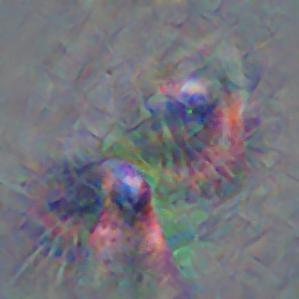

Iterations: 750, loss: -18.487632751464844, pred.: sea_lion, conf.: [0.999946]


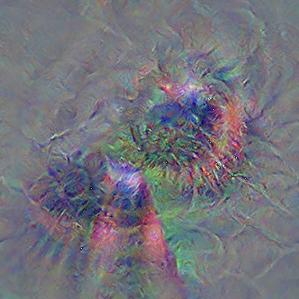

Iterations: 800, loss: -13.72339153289795, pred.: sea_lion, conf.: [0.9960991]


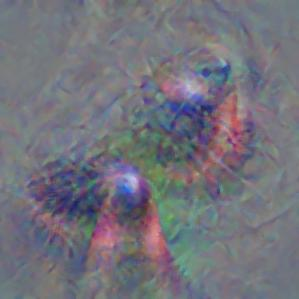

Iterations: 850, loss: -21.475696563720703, pred.: sea_lion, conf.: [0.99999785]


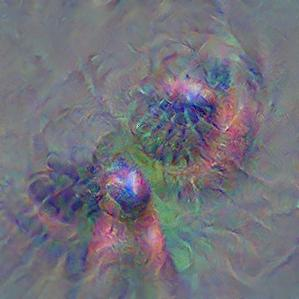

Iterations: 900, loss: -22.197032928466797, pred.: sea_lion, conf.: [0.99999666]


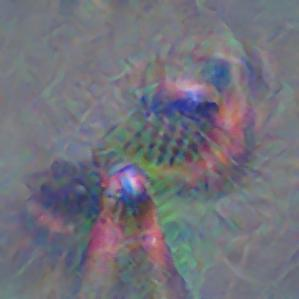

Iterations: 950, loss: -17.307601928710938, pred.: sea_lion, conf.: [0.99991024]


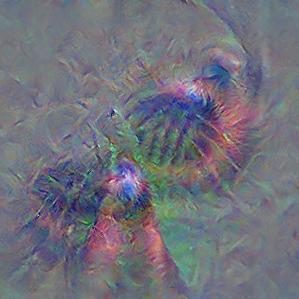

Iterations: 1000, loss: -18.053176879882812, pred.: sea_lion, conf.: [0.999863]


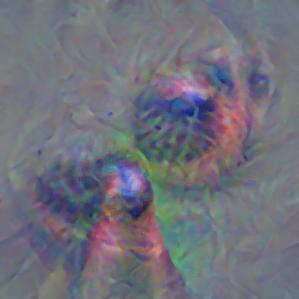

Iterations: 1050, loss: -16.36153793334961, pred.: sea_lion, conf.: [0.9998047]


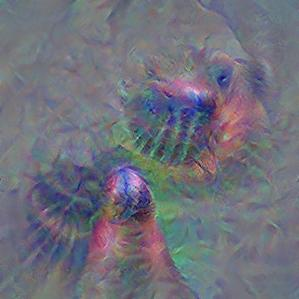

Iterations: 1100, loss: -17.066896438598633, pred.: sea_lion, conf.: [0.99985623]


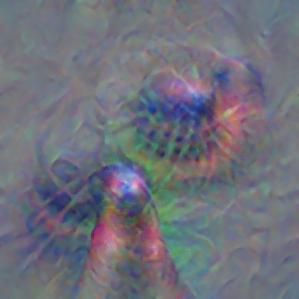

Iterations: 1150, loss: -11.944716453552246, pred.: sea_lion, conf.: [0.73013437]


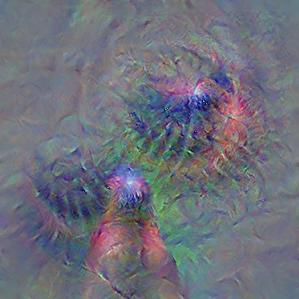

Iterations: 1200, loss: -15.350119590759277, pred.: sea_lion, conf.: [0.9985648]


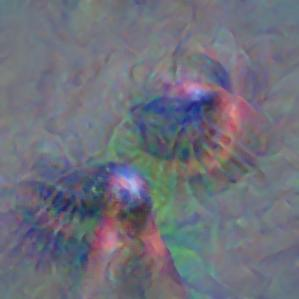

Iterations: 1250, loss: -23.985919952392578, pred.: sea_lion, conf.: [0.99999785]


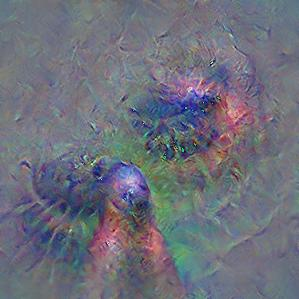

Iterations: 1300, loss: -18.86467742919922, pred.: sea_lion, conf.: [0.9998067]


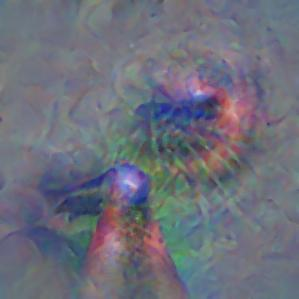

Iterations: 1350, loss: -16.094398498535156, pred.: sea_lion, conf.: [0.99971026]


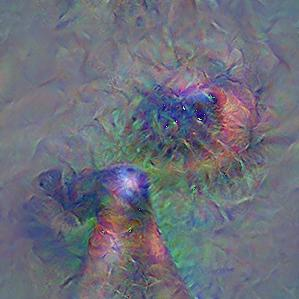

Iterations: 1400, loss: -18.993389129638672, pred.: sea_lion, conf.: [0.9999783]


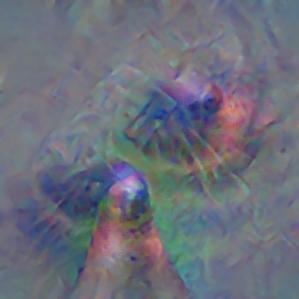

Iterations: 1450, loss: -16.654775619506836, pred.: sea_lion, conf.: [0.9997937]


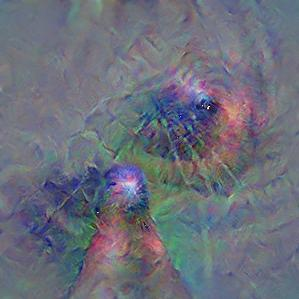

Iterations: 1500, loss: -17.343902587890625, pred.: sea_lion, conf.: [0.99917966]


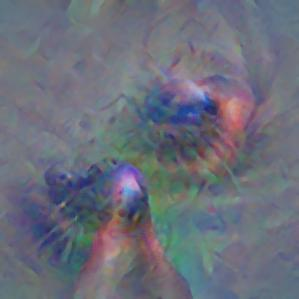

Iterations: 1550, loss: -23.300552368164062, pred.: sea_lion, conf.: [0.9999981]


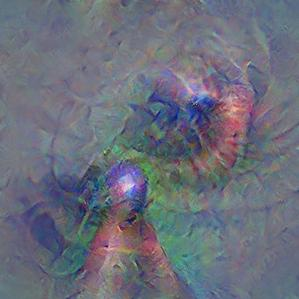

Iterations: 1600, loss: -8.29521369934082, pred.: feather_boa__boa, conf.: [0.05363129]


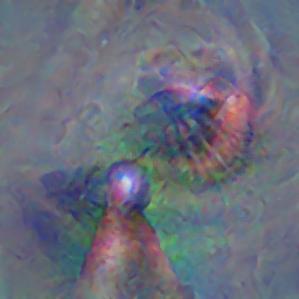

Iterations: 1650, loss: -22.84075355529785, pred.: sea_lion, conf.: [0.9999521]


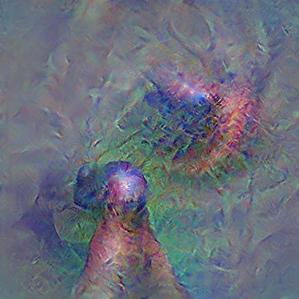

Iterations: 1700, loss: -21.076601028442383, pred.: sea_lion, conf.: [0.99998605]


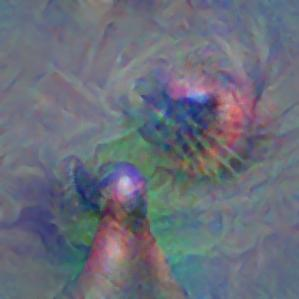

Iterations: 1750, loss: -17.784029006958008, pred.: sea_lion, conf.: [0.99933076]


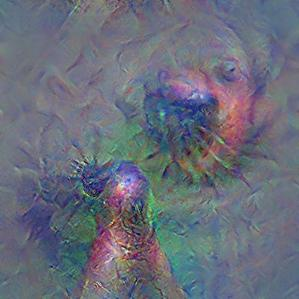

Iterations: 1800, loss: -17.2943172454834, pred.: sea_lion, conf.: [0.9998698]


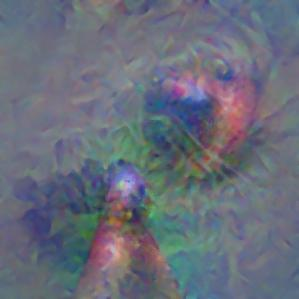

Iterations: 1850, loss: -14.311470985412598, pred.: sea_lion, conf.: [0.99813986]


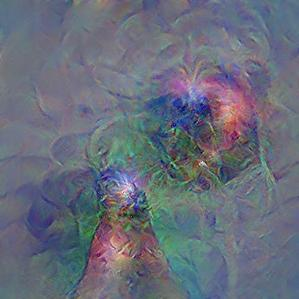

Iterations: 1900, loss: -18.474689483642578, pred.: sea_lion, conf.: [0.9998646]


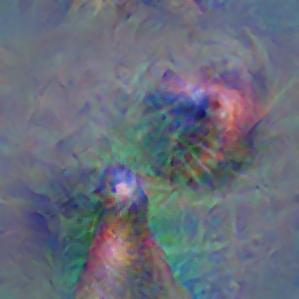

Iterations: 1950, loss: -16.099830627441406, pred.: sea_lion, conf.: [0.99925965]


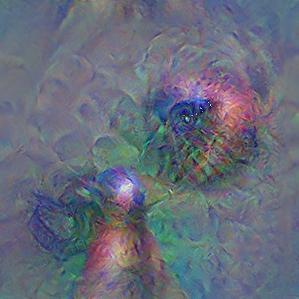

In [7]:
noise = gray_square(299)
img = gradient_ascent(noise, 150, f1)